In [198]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import MDAnalysis.analysis.distances
import networkx as nx
import scipy.stats
from itertools import product as product

In [4]:
u=mda.Universe('../f8bt_psma200/nvt-eq/int_npt.tpr',
               '../f8bt_psma200/nvt-eq/int_npt_skip1.xtc',
               '../f8bt_psma200/nvt-eq/int_npt_skip2.xtc')

In [5]:
###intrinsic density code... need for slab and monolayers...

In [164]:
###quick clustering check

core = u.select_atoms('resname UNK')
cutoff_cluster = 25


cluster_atoms = core.select_atoms('name '+str(core.atoms.names[0]))

dist_array=MDAnalysis.analysis.distances.contact_matrix(cluster_atoms.atoms.positions,cutoff=cutoff_cluster,box=u.dimensions)

G = nx.from_numpy_matrix(dist_array)
clusters=[h for h in nx.connected_components(G)]

for c in clusters:
    if len(c)==max([len(c_) for c_ in clusters]):
        slab_resids = [i+1 for i in  c]

In [166]:
###make sure the core selection doesn't break up and save positions as slab_calc_positions
core = core.select_atoms('resid '+str(' '.join([str(i) for i in slab_resids])))
# bonds_original=core.bonds
new_bond_atoms = core.select_atoms('name '+str(core.atoms.names[0]))
new_bonds=[((int(new_bond_atoms[i].index)),(int(new_bond_atoms[i+1].index))) for i in range(len(new_bond_atoms)-1)]
u.add_bonds(new_bonds)


In [103]:

def planar_intrinsic_density(u,timestep,core,selection,no_bins):
    
    u.trajectory[timestep] #for example

    ###quick clustering check

#     core = u.select_atoms('resname UNK')
    cutoff_cluster = 25
    core=core
    cluster_atoms = core.select_atoms('name '+str(core.atoms.names[0]))

    dist_array=MDAnalysis.analysis.distances.contact_matrix(cluster_atoms.atoms.positions,cutoff=cutoff_cluster,box=u.dimensions)

    G = nx.from_numpy_matrix(dist_array)
    clusters=[h for h in nx.connected_components(G)]

    for c in clusters:
        if len(c)==max([len(c_) for c_ in clusters]):
            slab_resids = [i+1 for i in  c]
   
    ###make sure the core selection doesn't break up and save positions as slab_calc_positions
    core = core.select_atoms('resid '+str(' '.join([str(i) for i in slab_resids])))
    # bonds_original=core.bonds
    new_bond_atoms = core.select_atoms('name '+str(core.atoms.names[0]))
    new_bonds=[((int(new_bond_atoms[i].index)),(int(new_bond_atoms[i+1].index))) for i in range(len(new_bond_atoms)-1)]
    u.add_bonds(new_bonds)


    #just take x,y as is and update z using this protocol
    #then just duplicate the positions of the solvent etc by taking away the box size in  z and go for certain distance only...
    #only valid until half way ...
    
    
    
    slab_calc_postions=np.zeros_like(core.positions)
    slab_calc_postions[:,0:2]=core.positions[:,0:2] #x and y positions can be from initial wrapped traj
    
    core.unwrap()
    
    slab_calc_postions[:,2]=core.positions[:,2]  #z positions can be from the newly unwrapped traj
    
    
    lower_interface = scipy.stats.binned_statistic_2d(slab_calc_postions[:,0]%u.dimensions[0],
                                                     slab_calc_postions[:,1]%u.dimensions[1],
                                                     slab_calc_postions[:,2],
                                                      bins=[np.linspace(0,u.dimensions[0],no_bins),np.linspace(0,u.dimensions[0],no_bins)],
                                                     statistic=np.min)
    
    upper_interface = scipy.stats.binned_statistic_2d(slab_calc_postions[:,0]%u.dimensions[0],
                                                     slab_calc_postions[:,1]%u.dimensions[1],
                                                     slab_calc_postions[:,2],
                                                      bins=[np.linspace(0,u.dimensions[0],no_bins),np.linspace(0,u.dimensions[0],no_bins)],
                                                     statistic=np.max)
    
    sel_grid_positions = scipy.stats.binned_statistic_2d(selection.positions[:,0]%u.dimensions[0],
                                                 selection.positions[:,1]%u.dimensions[1],
                                                 selection.positions[:,2],##can I add the change here?
                                                 bins=[np.linspace(0,u.dimensions[0],no_bins),np.linspace(0,u.dimensions[0],no_bins)],
                                                 statistic='count',
                                                 expand_binnumbers=True)
    
    intrinsic_z_=[]
    
    for atom in range(len(selection)):
        interface_position = lower_interface.statistic[sel_grid_positions.binnumber[0][atom]-1,sel_grid_positions.binnumber[1][atom]-1]
        intrinsic_z_.append(selection.positions[atom,2]-interface_position)

    return intrinsic_z_



In [199]:

def planar_intrinsic_density(u,timestep,
                             core_sel,
                             density_sel,
                             interface,
                             no_bins,
                             cluster=True,
                             recombine=True,
                            interpolate_interface=False):
    '''
    u:   MDAnalysis Universe
    
    core_sel: the atom selection that describes the reference object (membrane, slab, etc.)
    
    density_sel: the atom selection for which the intrinsic density is to be calculated
    
    interface: "Lower" or "Upper" interface of core_sel to calculate intrinsic density from 
    
    no_bins: number of bins in each lateral dimension (larger number gives finer grid) see 
    Ziolek et al Langmuir 2019 SI for discussion of grid size effects
    
    cluster: check whether any core_sel molecules have diffused out of the main structure 
    
    recombine: slow step that recombines the core_sel structure if it's split over the z PBC

    interpolate_interface: simple linear interpolation of the intrinsic interface, useful 
                          for patchy monolayers, etc. (like Ziolek et al Langmuir 2019 )
    '''

    u.trajectory[timestep] 

    ### clustering check  
    
    core = u.select_atoms(core_sel)
    
    if cluster==True:
            
        cutoff_cluster = 25

        cluster_atoms = core.select_atoms('name '+str(core.atoms.names[0]))

        dist_array=MDAnalysis.analysis.distances.contact_matrix(cluster_atoms.atoms.positions,cutoff=cutoff_cluster,box=u.dimensions)

        G = nx.from_numpy_matrix(dist_array)
        clusters=[h for h in nx.connected_components(G)]

        for c in clusters:
            if len(c)==max([len(c_) for c_ in clusters]):
                slab_resids = [i+1 for i in  c] #from np array to resids

        ###make sure the core selection doesn't break up and save positions as slab_calc_positions
        core = core.select_atoms('resid '+str(' '.join([str(i) for i in slab_resids])))

    ### make whole in z direction if slab/bilayer is split

    if recombine==True:

        # bonds_original=core.bonds
        new_bond_atoms = core.select_atoms('name '+str(core.atoms.names[0]))
        new_bonds=[((int(new_bond_atoms[i].index)),(int(new_bond_atoms[i+1].index))) for i in range(len(new_bond_atoms)-1)]
        u.add_bonds(new_bonds)


    #just take x,y as is and update z using this protocol
    #then just duplicate the positions of the solvent etc by taking away the box size in  z and go for certain distance only...
    #only valid until half way ...
    


        slab_calc_postions=np.zeros_like(core.positions)
        
        slab_calc_postions[:,0:2]=core.positions[:,0:2] #x and y positions can be from initial wrapped traj

        core.unwrap()

        slab_calc_postions[:,2]=core.positions[:,2]  #z positions can be from the newly unwrapped traj
    
    elif recombine==False:
        
        slab_calc_postions=np.zeros_like(core.positions)
        slab_calc_postions=core.positions
        
    if interface=='Lower':
        
        interface_grid = scipy.stats.binned_statistic_2d(slab_calc_postions[:,0]%u.dimensions[0],
                                                     slab_calc_postions[:,1]%u.dimensions[1],
                                                     slab_calc_postions[:,2],
                                                      bins=[np.linspace(0,u.dimensions[0],no_bins),np.linspace(0,u.dimensions[0],no_bins)],
                                                     statistic=np.min)
        interface_grid=interface_grid.statistic
    else:
        
        interface_grid = scipy.stats.binned_statistic_2d(slab_calc_postions[:,0]%u.dimensions[0],
                                                     slab_calc_postions[:,1]%u.dimensions[1],
                                                     slab_calc_postions[:,2],
                                                      bins=[np.linspace(0,u.dimensions[0],no_bins),np.linspace(0,u.dimensions[0],no_bins)],
                                                     statistic=np.max)
        interface_grid=interface_grid.statistic
        
    selection=u.select_atoms(density_sel)
    sel_grid_positions = scipy.stats.binned_statistic_2d(selection.positions[:,0]%u.dimensions[0],
                                                 selection.positions[:,1]%u.dimensions[1],
                                                 selection.positions[:,2],##can I add the change here?
                                                 bins=[np.linspace(0,u.dimensions[0],no_bins),np.linspace(0,u.dimensions[0],no_bins)],
                                                 statistic='count',
                                                 expand_binnumbers=True)
    
    if interpolate_interface==True:
        box_ = u.dimensions
        

        while np.count_nonzero(~np.isnan(interface_grid))!=(len(np.linspace(0,box_[0],num=no_bins))-1)*(len(np.linspace(0,box_[0],num=no_bins))-1):
            
            for i in range(len(interface_grid)):
                for j in range(len(interface_grid)):

                    if np.isnan(interface_grid[i][j]):
                        n_i=[i-1,i,i+1]
                        n_j=[j-1,j,j+1]
                        interface_grid[i][j]=np.nanmean([interface_grid[divmod(ip,len(interface_grid))[1]][divmod(jp,len(interface_grid))[1]] for ip,jp in product(n_i,n_j)])

    
    intrinsic_z_=[]
    
    for atom in range(len(selection)):
        interface_position = interface_grid[sel_grid_positions.binnumber[0][atom]-1,sel_grid_positions.binnumber[1][atom]-1]
        intrinsic_z_.append(selection.positions[atom,2]-interface_position)

    half_z = u.trajectory[timestep].dimensions[2]/2
    
    new_intrinsic_z_=[]
    
    for atom in intrinsic_z_:
        
        if atom > half_z:
            new_intrinsic_z_.append(atom-half_z*2)
        elif atom < -half_z:

            new_intrinsic_z_.append(atom+half_z*2)

        else:
            new_intrinsic_z_.append(atom)

    return intrinsic_z_,new_intrinsic_z_


In [191]:

# plt.matshow(lower_interface.statistic)
# plt.colorbar()
# plt.show()

# plt.matshow(upper_interface.statistic)
# plt.colorbar()
# plt.show()

In [202]:
#intrinsic density - does one frame at a time for flexibility and RAM reqs
z_o = np.zeros([len(np.arange(-30,50,1))])

for ts in u.trajectory[-100::20]:
    
    z,z_fixed = planar_intrinsic_density(u,
                                 timestep=ts.frame,
                                 core_sel='resname UNK and prop mass >2',
                                 density_sel='resname SMA and type C*',
                                 interface='Lower', #Lower or Upper... 
                                 no_bins=51,
                                 recombine=True, ###set true if you're using a slab/bilayer
                                 cluster=True,#if you want to check if anything has escaped slab/bilayer so it's not included
                                 interpolate_interface=False)#if it's patchy...
#                                  interpolate_interface=True) 
    ###might only want to use cluster for bilayers...
    y,a,b=plt.hist(np.array(z),bins=np.arange(-30.5,50,1))
    plt.close()
    z_o+=y
    print(ts)

< Timestep 882 with unit cell dimensions [158.3801  158.3801  190.30975  90.       90.       90.     ] >
< Timestep 902 with unit cell dimensions [158.3801  158.3801  190.19746  90.       90.       90.     ] >


KeyboardInterrupt: 

In [181]:
interface_grid

NameError: name 'interface_grid' is not defined

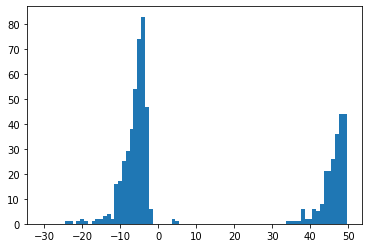

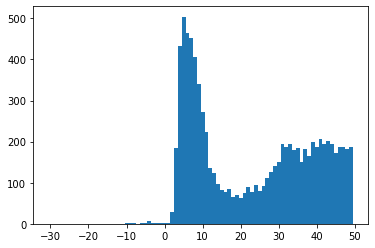

In [203]:
plt.hist(np.array(z),bins=np.arange(-30.5,50,1))
plt.show()
plt.hist(-np.array(z_fixed),bins=np.arange(-30.5,50,1))
plt.show()


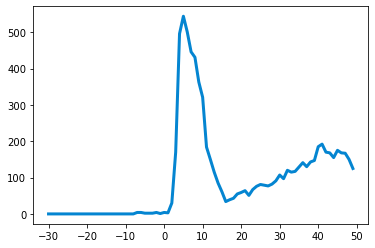

In [139]:
plt.plot(np.arange(-30,50,1),y,lw=3,c='xkcd:cerulean')
plt.show()

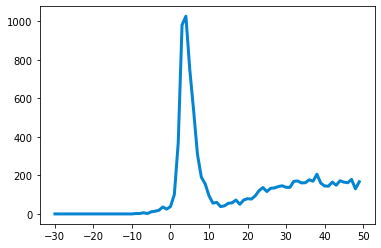

In [32]:
plt.plot(np.arange(-30,50,1),z_o,lw=3,c='xkcd:cerulean')
plt.show()

In [72]:
#intrinsic tracking (can do by carefully designing main fn and still low RAM req...)

intrinsic_z_tracking=[]

for ts in u.trajectory[-100::20]:
    
    z,z_fixed = planar_intrinsic_density(u,
                                 timestep=ts.frame,
                                 core_sel='resname UNK and prop mass >2',
                                 density_sel='resname SMA and type C*',
                                 interface='Lower', 
                                 no_bins=51,
                                 recombine=True, ###set true if you're using a slab/bilayer
                                 cluster=True) #if you want to check if anything has escaped slab/bilayer so it's not included
    ###might only want to use cluster for bilayers...

    intrinsic_z_tracking.append(z)
    print(ts)

< Timestep 882 with unit cell dimensions [158.3801  158.3801  190.30975  90.       90.       90.     ] >


KeyboardInterrupt: 

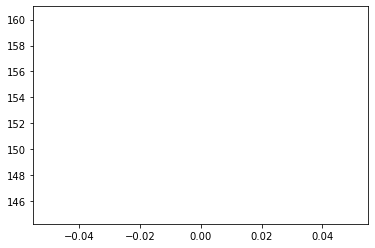

In [73]:
#example of other calcs (angle, mobility, etc.)
plt.plot([i[4] for i in intrinsic_z_tracking])
plt.show()

In [ ]:
###could make this work for monolayer (and patchy) by setting recomb off (making sel before...)
### and by setting clustering off for patchy...
